# Packages Loading

In [1]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from numpy import linalg as LA
from random import randint
import pandas as pd
import numpy as np
import random
import math

# Data Import

In [56]:
df_train = np.array(pd.read_table('./EMGaussian.data')).tolist()
df_test = np.array(pd.read_table('./EMGaussian.test')).tolist()

train = [[float(x[0].split(' ')[0]), float(x[0].split(' ')[1])] for x in df_train]
test = [[float(x[0].split(' ')[0]), float(x[0].split(' ')[1])] for x in df_test]
df_train_x_1 = [float(x[0].split(' ')[0]) for x in df_train]
df_train_x_2 = [float(x[0].split(' ')[1]) for x in df_train]
df_test_x_1 = [float(x[0].split(' ')[0]) for x in df_test]
df_test_x_2 = [float(x[0].split(' ')[1]) for x in df_test]

# Forward and Backward recursions

In [3]:
### parameters
K = 4
T = len(df_train)

# sumlog function
def logplus(vect):
    n = len(vect)
    max_vect = max(vect)
    sum_exp = np.zeros(shape=(n,1))
    for i in range(0,n):
        sum_exp[i] = np.exp(vect[i]-max_vect)
    return max_vect + np.log(np.sum(sum_exp))

In [4]:
### forward recursion - log_alpha computation
def forward_rec(log_alpha,log_A,T,mu,sigma,log_pi):
    #init
    for i in range(0,K):
        log_alpha[0][i] = log_pi[i] + multivariate_normal.logpdf(train[0],mu[i].ravel(),sigma[i])
    #rec
    for c in range(1,T):
        for i in range(0,K):
            log_sum = np.zeros(shape=(K,1))
            for j in range(0,K):
                log_sum[j] = log_A[i][j] + log_alpha[c-1][j]
            log_alpha[c][i] = multivariate_normal.logpdf(train[c],mu[i].ravel(),sigma[i]) + logplus(log_sum)
    return log_alpha

In [5]:
### backward recursion - log_beta computation
def backward_rec(log_beta,log_A,T,mu,sigma,log_pi):
    #init
    for i in range(0,K):
        log_beta[T-1][i] = 0
    #rec
    for c in range(2,T+1):
        index = T-c
        for i in range(0,K):
            log_sum = np.zeros(shape=(K,1))
            for j in range(0,K):
                log_sum[j] = log_A[i][j] + multivariate_normal.logpdf(train[index+1],mu[j].ravel(),sigma[j]) + log_beta[index+1][j]
            log_beta[index][i] = logplus(log_sum)
    return log_beta

### compute $log(p(u_0,...,u_T))$

In [6]:
def logZ(t,T,log_alpha,log_beta):
    vect = np.zeros(shape=(K,1))
    for i in range(0,K):
        vect[i] = log_alpha[t][i] + log_beta[t][i]
    return logplus(vect)

### compute $log(p(q_t = i|u_1,...,u_T))$

In [7]:
def log_p1(t,T,i,log_alpha,log_beta):
    log_Z = logZ(t,T,log_alpha,log_beta)
    result = -log_Z + log_alpha[t][i] + log_beta[t][i]
    return result

### compute $log(p(q_t = i,q_{t+1} = j|u_1,...,u_T))$

In [8]:
def log_p2(t,T,i,j,log_A,log_alpha,log_beta,train,mu,sigma):
    if t < T:
        log_Z = logZ(t,T,log_alpha,log_beta)
        result = -log_Z + log_alpha[t][i] + log_beta[t+1][j] + log_A[i][j] + multivariate_normal.logpdf(train[t+1],mu[j].ravel(),sigma[j])
        return result

# EM code for GMM

In [89]:
def norm2(mat):
    dim = mat.shape
    sum = 0
    for i in range(0,dim[0]):
        for j in range(0,dim[1]):
            sum = sum + mat[i,j]**2
    return np.sqrt(sum)

def init_kmean(n,K,tau,mu_current):
    for i in range(0,n):
        add = []
        for j in range(0,K):
            dist_current = np.sqrt( (df_train_x_1[i] - mu_current[j][0])**2 + (df_train_x_2[i] - mu_current[j][1])**2 )
            add.append(dist_current)
        for j in range(0,K):
            if add.index(min(add)) == j:
                    tau[i,j] = 1
            else:
                    tau[i,j] = 0
    return tau

def init(n,K,df_train_x_1,df_train_x_2):
    ### K-mean algorithm ###
    mu = [[0,0]]*K
    # random initialization of the algorithm on the plane
    for i in range(0,K):
        rand1 = random.uniform(-10,10)
        rand2 = random.uniform(-10,10)
        mu[i] = [rand1,rand2]
    itermax = 200
    it = 0
    epsilon_kmean = 1e-8
    converged = False 
    mu_current = mu
    norm = [0]*K # store the mean variations between two consecutive iterations

    while ( it<itermax and not(converged) ) :

        #determine new class label for each data point (latent variables)
        classes = [[]]*K
        objective = []
        for j in range(0,n-1):
            add = []
            for i in range(0,K):
                dist_current = np.sqrt( (df_train_x_1[j] - mu_current[i][0])**2 + (df_train_x_2[j] - mu_current[i][1])**2 )
                add.append(dist_current)
            classes[add.index(min(add))] = classes[add.index(min(add))] + [[df_train_x_1[j], df_train_x_2[j]]]
            objective.append(add[add.index(min(add))])

        #compute the new centroïds
        mu_next = [[0,0]]*K
        for i in range(0,K):
            mu_x_1 = np.mean([elem[0] for elem in classes[i]])
            mu_x_2 = np.mean([elem[1] for elem in classes[i]])
            mu_next[i] = [mu_x_1, mu_x_2]
            norm[i] = np.sqrt( (mu_next[i][0] - mu_current[i][0])**2 + (mu_next[i][1] - mu_current[i][1])**2 ) 

        # check threshold
        if max(norm)<epsilon_kmean:
            converged = True

        #iterate
        it = it + 1
        mu_current = mu_next

    ### EM algorithm - applied to Gaussian mixture ###
    ### with covariance matrix proportional to identity 
    #initialization of the algorithm using k-means 
    ### E-steps and M-steps iterations ###
    ### initialization of the parameters with K-means algorithm
    tau_init = init_kmean(n,K,np.zeros(shape=(n,K)),mu_current) # k-means computation
    mu_star_general_init = [[0,0]]*K
    pi_star_general_init = [0]*K
    sigma_general_init = [0]*K
    # init mean called mu_star
    for j in range(0,K):
        tau_column = tau_init[:,j]
        sum_x1 = 0
        sum_x2 = 0
        for i in range(0,n-1): 
            sum_x1 = sum_x1 + tau_init[i,j]*df_train_x_1[i]
            sum_x2 = sum_x2 + tau_init[i,j]*df_train_x_2[i]
        mu_star_general_init[j] = [sum_x1/tau_column.sum(), sum_x2/tau_column.sum()]
    # init pi_star (normalized)
    for j in range(0,K):
        tau_column = tau_init[:,j]
        pi_star_general_init[j] = (1/n)*tau_column.sum()
    # init general covariances 
    for j in range(0,K):
        tau_column = tau_init[:,j]
        sum = np.zeros(shape=(2,2))
        for i in range(0,n-1): 
            arr = np.array([df_train_x_1[i], df_train_x_2[i]]) - np.array([mu_star_general_init[j][0],mu_star_general_init[j][1]])
            arr.shape = (2,1)
            sum = sum + tau_init[i,j]*arr.dot(arr.transpose())
        sigma_general_init[j] = (1/tau_column.sum())*sum

    mu_star_general_current = mu_star_general_init
    pi_star_general_current = pi_star_general_init
    sigma_general_current = sigma_general_init

    # new tau_general init matrix using general init parameters computed above
    for i in range(0,n-1):
    # normalization factor computation
        sum = 0
        for j in range(0,K):
            arr = np.array([df_train_x_1[i], df_train_x_2[i]]) - np.array([mu_star_general_init[j][0],mu_star_general_init[j][1]])
            arr.shape = (1,2)
            mult = arr.dot(np.linalg.inv(sigma_general_init[j]))
            sum = sum + pi_star_general_init[j]*(1/np.sqrt(np.linalg.det(sigma_general_init[j])))*np.exp(-0.5*mult.dot(arr.transpose()))
        # conditional probabilities computations
        for j in range(0,K):
            arr = np.array([df_train_x_1[i], df_train_x_2[i]]) - np.array([mu_star_general_init[j][0],mu_star_general_init[j][1]])
            arr.shape = (1,2)
            mult = arr.dot(np.linalg.inv(sigma_general_init[j]))
            tau_init[i,j] = (1/sum)*pi_star_general_init[j]*(1/np.sqrt(np.linalg.det(sigma_general_init[j])))*np.exp(-0.5*mult.dot(arr.transpose()))
    # convergence parameters
    norm_EM_2 = [[0,0]]*K # store the parameters variations between two consecutive iterations
    epsilon_EM_2 = 1e-8
    converged = False 
    itermax_2 = 200
    it_2 = 0
    tau = tau_init

    while ( it_2<itermax_2 and not(converged) ):

        mu_star_general_next = [[0,0]]*K
        pi_star_general_next = [0]*K
        sigma_general_next = [0]*K

        # new mean called mu_star
        for j in range(0,K):
            tau_column = tau[:,j]
            sum_x1 = 0
            sum_x2 = 0
            for i in range(0,n-1): 
                sum_x1 = sum_x1 + tau[i,j]*df_train_x_1[i]
                sum_x2 = sum_x2 + tau[i,j]*df_train_x_2[i]
            mu_star_general_next[j] = [sum_x1/tau_column.sum(), sum_x2/tau_column.sum()]
            norm_EM_2[j][0] =  (mu_star_general_next[j][0] - mu_star_general_current[j][0])**2 + (mu_star_general_next[j][1] - mu_star_general_current[j][1])**2 

        # new pi_star (normalized)
        for j in range(0,K):
            tau_column = tau[:,j]
            pi_star_general_next[j] = (1/n)*tau_column.sum()

        # new general covariances 
        for j in range(0,K):
            tau_column = tau[:,j]
            sum = np.zeros(shape=(2,2))
            for i in range(0,n-1): 
                arr = np.array([df_train_x_1[i], df_train_x_2[i]]) - np.array([mu_star_general_next[j][0],mu_star_general_next[j][1]])
                arr.shape = (2,1)
                sum = sum + tau_init[i,j]*arr.dot(arr.transpose())
            sigma_general_next[j] = (1/tau_column.sum())*sum
            norm_EM_2[j][1] = LA.norm(sigma_general_next[j]-sigma_general_current[j],2)

        # new tau_general matrix
        for i in range(0,n-1):
            # normalization factor computation
            sum = 0
            for j in range(0,K):
                arr = np.array([df_train_x_1[i], df_train_x_2[i]]) - np.array([mu_star_general_next[j][0],mu_star_general_next[j][1]])
                arr.shape = (1,2)
                mult = arr.dot(np.linalg.inv(sigma_general_next[j]))
                sum = sum + pi_star_general_next[j]*(1/(2*np.pi))*(1/np.sqrt(np.linalg.det(sigma_general_next[j])))*np.exp(-0.5*mult.dot(arr.transpose()))
            # probabilities computations
            for j in range(0,K):
                arr = np.array([df_train_x_1[i], df_train_x_2[i]]) - np.array([mu_star_general_next[j][0],mu_star_general_next[j][1]])
                arr.shape = (1,2)
                mult = arr.dot(np.linalg.inv(sigma_general_next[j]))
                tau[i,j] = (1/sum)*pi_star_general_next[j]*(1/(2*np.pi))*(1/np.sqrt(np.linalg.det(sigma_general_next[j])))*np.exp(-0.5*mult.dot(arr.transpose()))

        # check threshold
        if max([max(list) for list in norm_EM_2])<epsilon_EM_2:
            converged = True

        it_2 = it_2 + 1
        mu_star_general_current = mu_star_general_next
        pi_star_general_current = pi_star_general_next
        sigma_general_current = sigma_general_next
        
    return np.array(mu_star_general_current), np.array(pi_star_general_current), np.array(sigma_general_current), classes, tau


### output of EM with GMM and initialization of parameters for EM with HMM

In [91]:
### initialization of parameters
# initialization of pi, covariances and means
mu_current, pi_current, sigma_current, classes_gmm, tau = init(T,K,df_train_x_1,df_train_x_2)
mu_gmm, pi_gmm, sigma_gmm = mu_current, pi_current, sigma_current

### Vizualisation for GMM

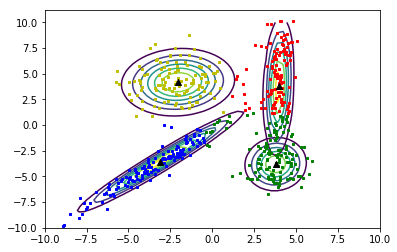

In [92]:
### plot of data points + covariance matrix
colors = ['bs','gs','ys','rs']
for j in range(0,K):
    mu = mu_current[j]
    Sigma = sigma_current[j]
    N = 60
    X = np.linspace(-10, 10, N)
    Y = np.linspace(-10, 10, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    F = multivariate_normal(mu, Sigma)
    Z = F.pdf(pos)
    plt.plot([elem[0] for elem in classes_gmm[j]],[elem[1] for elem in classes_gmm[j]],colors[j],markersize=2,zorder=2)
    plt.contour(X,Y,Z,zorder=1)
    plt.scatter(mu[0],mu[1],marker='^',color='black',zorder=3)
plt.show()

# EM for HMM

In [76]:
# initialization of other parameters
log_pi = np.log(pi_current)
log_A = np.log(0.25)*np.ones(shape=(K,K)) #uniform transition probabilities
log_alpha = np.zeros(shape=(T,K))
log_beta = np.zeros(shape=(T,K))
log_p_vect = np.zeros(shape=(T,K))
log_p_mat = np.zeros(shape=(T,K,K))
classes_hmm = [[]]*K

# convergence meta-parameters
norm_EM_2 = [0,0] # store the parameters variations between two consecutive iterations
epsilon_EM = 1e-8
converged = False 
itermax = 30
it = 0

while ( it<itermax and not(converged) ):
    
    #init next parameters
    mu_next = [np.zeros(shape=(2,1))]*K
    sigma_next = [np.zeros(shape=(2,2))]*K
    
    #update alpha and beta
    log_alpha = forward_rec(log_alpha,log_A,T,mu_current,sigma_current,log_pi)
    log_beta = backward_rec(log_beta,log_A,T,mu_current,sigma_current,log_pi)
    
    #update of log-probabilities
    for t in range(0,T-1):
        for i in range(0,K):
            log_p_vect[t,i] = log_p1(t,T,i,log_alpha,log_beta)
    for t in range(0,T-1):
        for i in range(0,K):
            for j in range(0,K):
                log_p_mat[t,i,j] = log_p2(t,T,i,j,log_A,log_alpha,log_beta,train,mu_current,sigma_current)
            
    #update of transitions matrix
    for a in range(0,K):
        for b in range(0,K):
            #log-sum instead of sum for better numerical accuracy
            sum2 = logplus(log_p_mat[:,a,b])
            sum1 = logplus(log_p_vect[:,b])
            log_A[a][b] = sum2 - sum1
    
    #update of pi
    for a in range(0,K):
        log_pi[a] = log_p_vect[0,a] - logplus(log_p_vect[0,:])
    
    #update of mu
    norms_mu = []
    for a in range(0,K):
        log_sum1 = logplus(log_p_vect[:,a])
        num = np.zeros(shape=(2,1))
        for t in range(0,T):
            num = num + np.exp(log_p_vect[t,a])*np.array(train[t]).reshape(2,1)
        mu_next[a] = np.exp(-log_sum1)*num
        norms_mu.append(LA.norm(mu_next[a]-mu_current[a],2))
    norm_EM_2[0] = max(norms_mu)
    
    #update of Sigma
    norms_sigma = []
    for a in range(0,K):
        log_sum1 = logplus(log_p_vect[:,a])
        num = np.zeros(shape=(2,2))
        for t in range(0,T-1):
            xt = np.array(train[t]).reshape(2,1)
            diff = xt-mu_next[a]
            num = num + np.exp(log_p_vect[t,a])*(diff.dot(diff.T))
        sigma_next[a] = np.exp(-log_sum1)*num
        norms_sigma.append(LA.norm(sigma_next[a]-sigma_current[a],2))
    norm_EM_2[1] = max(norms_sigma)
    
    #update of classes with Viterbi method
    for t in range(0,T-1):
        log_p = log_p_vect[t,:]
        index = np.argmax(log_p)
        classes_hmm[index] = classes_hmm[index] + [[train[t][0],train[t][1]]]

    # check threshold
    if max(norm_EM_2)<epsilon_EM:
        converged = True
    
    # define new current values
    it = it + 1
    mu_current = mu_next
    sigma_current = sigma_next

### Vizualisation for HMM

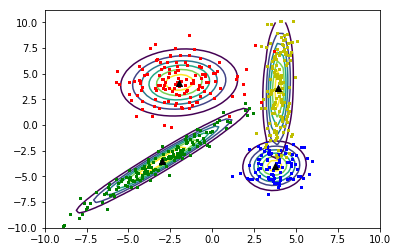

In [77]:
### plot of data points + covariance matrix
for j in range(0,K):
    mu = mu_current[j].ravel()
    Sigma = sigma_current[j]
    N = 60
    X = np.linspace(-10, 10, N)
    Y = np.linspace(-10, 10, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    F = multivariate_normal(mu, Sigma)
    Z = F.pdf(pos)
    plt.plot([elem[0] for elem in classes_hmm[j]],[elem[1] for elem in classes_hmm[j]],colors[j],markersize=2,zorder=2)
    plt.contour(X,Y,Z,zorder=1)
    plt.scatter(mu[0],mu[1],marker='^',color='black',zorder=3)
plt.show()

# Question 5

### Log-likelihood computations

In [81]:
def loglikelihood_hmm(T,K,log_pi,log_prob_vect,log_prob_mat,log_A,mu,sigma,train):
    log_sum1 = sum([np.exp(log_prob_vect[0,i])*log_pi[i] for i in range(0,K)])
    log_sum2 = 0
    log_sum3 = 0
    for t in range(0,T-1):
        log_sum2 = log_sum2 + sum([np.exp(log_prob_mat[t,i,j])*log_A[i][j] for i in range(0,K) for j in range(0,K)])
        log_sum3 = log_sum3 + sum([np.exp(log_prob_vect[t,i])*multivariate_normal.logpdf(train[t],mu[i].ravel(),sigma[i])])
    return log_sum1 + log_sum2 + log_sum3

In [82]:
def loglikelihood_gmm(T,K,log_pi,tau,mu,sigma,train):
    log_sum1 = 0
    log_sum2 = 0
    for t in range(0,T-1):
        log_sum1 = log_sum1 + sum([tau[t,i]*log_pi[i] for i in range(0,K)])
        log_sum2 = log_sum2 + sum([tau[t,i]*multivariate_normal.logpdf(train[t],mu[i].ravel(),sigma[i]) for i in range(0,K)])
    return log_sum1 + log_sum2

In [86]:
### HMM results :
T2 = len(df_test)
print('Normalized Log-Likelihood with HMM is')
print('- on Train : ' + str((1/T)*loglikelihood_hmm(T,K,log_pi,log_p_vect,log_p_mat,log_A,mu_current,sigma_current,train)))
print('- on Test : ' + str((1/T2)*loglikelihood_hmm(T2,K,log_pi,log_p_vect,log_p_mat,log_A,mu_current,sigma_current,test)))
### GMM results :
print('Normalized Log-Likelihood with GMM is')
print('- on Train : ' + str((1/T)*loglikelihood_gmm(T,K,np.log(pi_gmm),tau,mu_gmm,sigma_gmm,train)))
print('- on Test : ' + str((1/T2)*loglikelihood_gmm(T2,K,np.log(pi_gmm),tau,mu_gmm,sigma_gmm,test)))

Normalized Log-Likelihood with HMM is
- on Train : -1.4025362101701415
- on Test : -3.6698549273974375
Normalized Log-Likelihood with GMM is
- on Train : -10.055300464786516
- on Test : -33.304024004351874
